In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Load and unzip 
# !cp "/content/drive/My Drive/Face_Mask_Detection/FMD_DATASET_Split.zip" "Face_Mask"
# !unzip Face_Mask -d data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#importing dependencies related to nn
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
from PIL import Image

#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader

#importing Tensorboard for data visualization
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns   

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#defining image transformations

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [4]:
# loading data
data = {
    'train':
    datasets.ImageFolder(root='/content/data/FMD_DATASET/Train', transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root='/content/data/FMD_DATASET/Test', transform=image_transforms['test']),
}

# Dataloader iterators, used for making batches
dataloaders = {
    'train': DataLoader(data['train'], batch_size=100, shuffle=True),
    'test': DataLoader(data['test'], batch_size=100, shuffle=True)
}

In [5]:
#loading MobileNetv2
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
#freezing the initial layers of MobileNetv2
for param in model.parameters():
    param.requires_grad = False

In [7]:
#adding our own classifier
model.classifier = nn.Sequential(
                      nn.Linear(1280, 1024),
                      nn.ReLU(),
                      nn.Linear(1024, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(32, 3), 
                      nn.LogSoftmax(dim=1))

In [8]:
# !cp "/content/drive/My Drive/Face_Mask_Detection/Weights/Res-FaceMDN-epc-33-acc-0.9626373626373627.pth" "Trained_weight.pth"
# model = torch.load('Trained_weight.pth', map_location=lambda storage, loc: storage)
#model.load_state_dict(pretrained)

In [9]:
#checking trainable parameters
# print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1617475


In [10]:
#checking GPU Avaibility
if torch.cuda.is_available():
    print('training on GPU')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")

training on GPU


In [11]:
#training data
from tqdm.notebook import tqdm #for loading bars

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs,device):
    writer = SummaryWriter("saves/logs")
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        num_correct_train = 0 
        num_examples_train = 0
        for batch in (train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            #print(targets)
            output = model(inputs)
            #print(output)
            loss = loss_fn(output, targets)
            # loss.requires_grad = True
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
            correct_train = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            #y_pred.extend(correct.cpu().numpy())
            num_correct_train += torch.sum(correct_train).item()
            num_examples_train += correct_train.shape[0]
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        y_true = []
        y_pred = []
        for batch in (val_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            _, predicted = torch.max(output.data, 1)
            # print(predicted)
            targets = targets.to(device)
            y_true.extend(targets.cpu().numpy())
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)          
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            y_pred.extend(predicted.cpu().numpy())
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        cf_matrix = confusion_matrix(y_true, y_pred)
        #print(cf_matrix)
        class_names = ('incorrect_mask', 'with_mask', 'without_mask')
        # Create pandas dataframe
        dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
        plt.figure(figsize=(8, 6))
      
        # Create heatmap
        sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

        plt.title("Confusion Matrix"), plt.tight_layout()

        plt.ylabel("True Class"), 
        plt.xlabel("Predicted Class")
        plt.show()
        print('Epoch: {}, Training Loss: {:.4f}, Train Accuracy = {:.4f}, Validation Loss: {:.4f}, Val Accuracy = {:.4f}'.format(epoch+1, training_loss, num_correct_train / num_examples_train, valid_loss, num_correct / num_examples))
        
        #save model
        if(training_loss<0.1):
            torch.save(model,"/content/drive/My Drive/Face_Mask_Detection/Weights/Mobile-FaceMDN-epc-"+str(epoch+1)+"-acc-"+str(num_correct / num_examples)+".pth")
        
        #tensorBoard save log
        writer.add_scalar('Loss', loss.item(), epoch)
        writer.add_scalar('Train/Loss', training_loss, epoch)
        writer.add_scalar('Test/Loss', valid_loss, epoch)
        writer.add_scalar('Test/Accuracy',num_correct / num_examples, epoch)
        writer.flush()

In [12]:
#testing data
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [13]:
#put model to GPU (if available)
model=model.to(device)

In [14]:
#choosing optimizer and loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


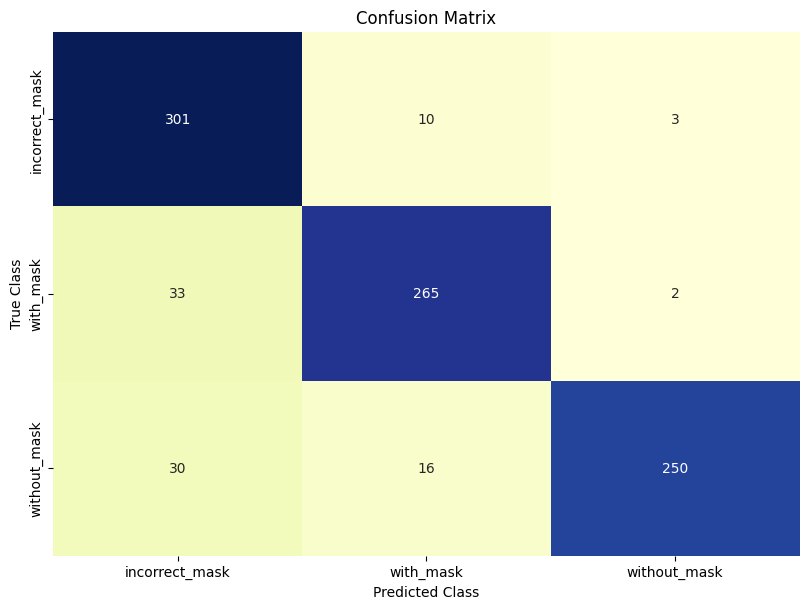

Epoch: 1, Training Loss: 0.3660, Train Accuracy = 0.8672, Validation Loss: 0.3195, Val Accuracy = 0.8967


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


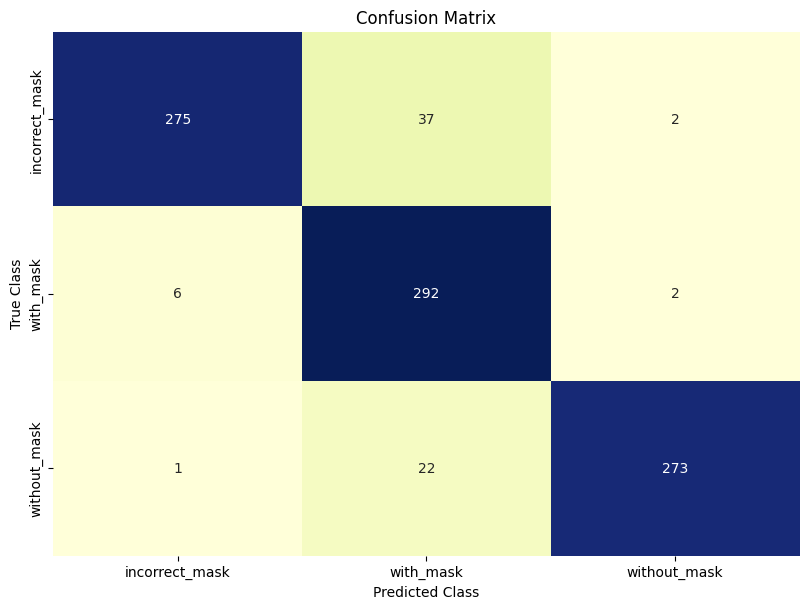

Epoch: 2, Training Loss: 0.2007, Train Accuracy = 0.9382, Validation Loss: 0.2031, Val Accuracy = 0.9231


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


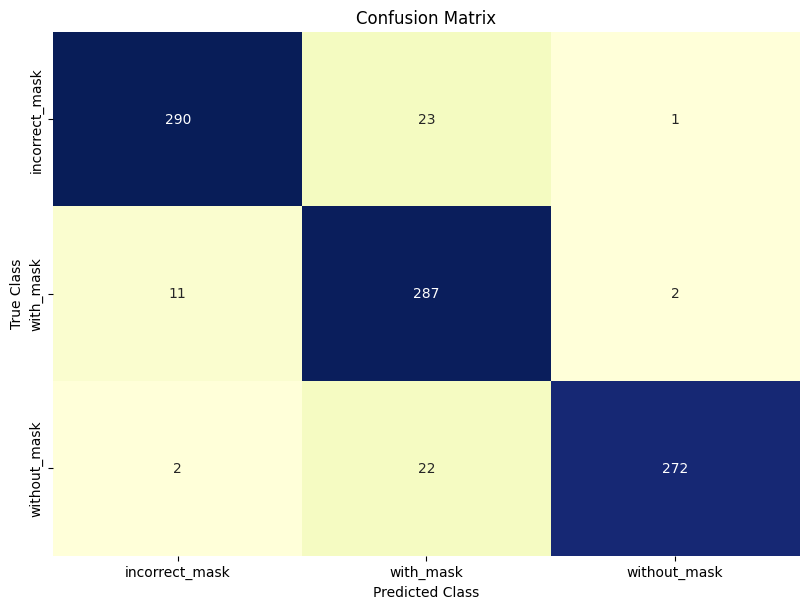

Epoch: 3, Training Loss: 0.1669, Train Accuracy = 0.9463, Validation Loss: 0.2022, Val Accuracy = 0.9330


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


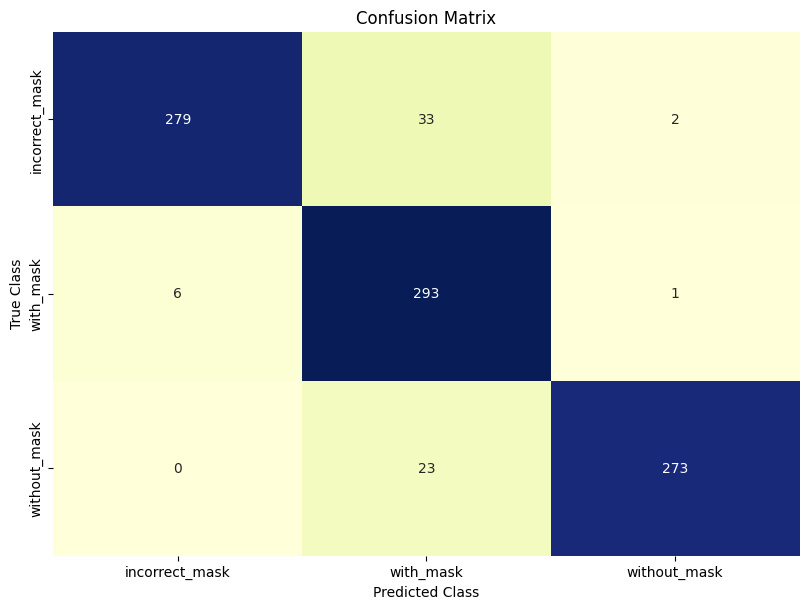

Epoch: 4, Training Loss: 0.1571, Train Accuracy = 0.9502, Validation Loss: 0.1706, Val Accuracy = 0.9286


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


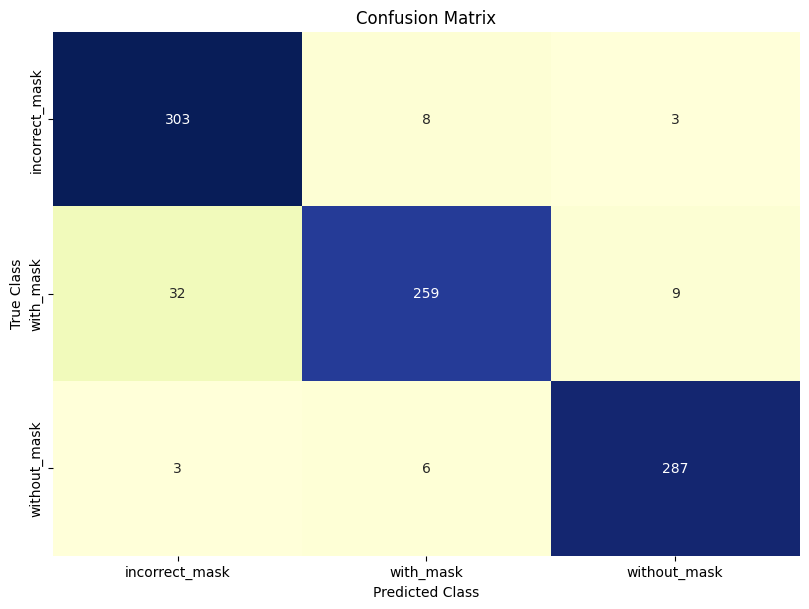

Epoch: 5, Training Loss: 0.1494, Train Accuracy = 0.9549, Validation Loss: 0.2103, Val Accuracy = 0.9330


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


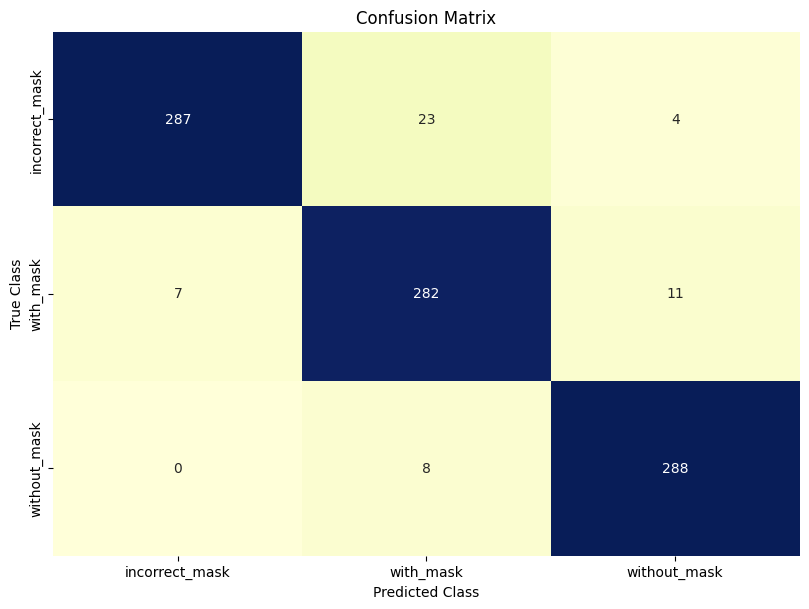

Epoch: 6, Training Loss: 0.1488, Train Accuracy = 0.9526, Validation Loss: 0.1408, Val Accuracy = 0.9418


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


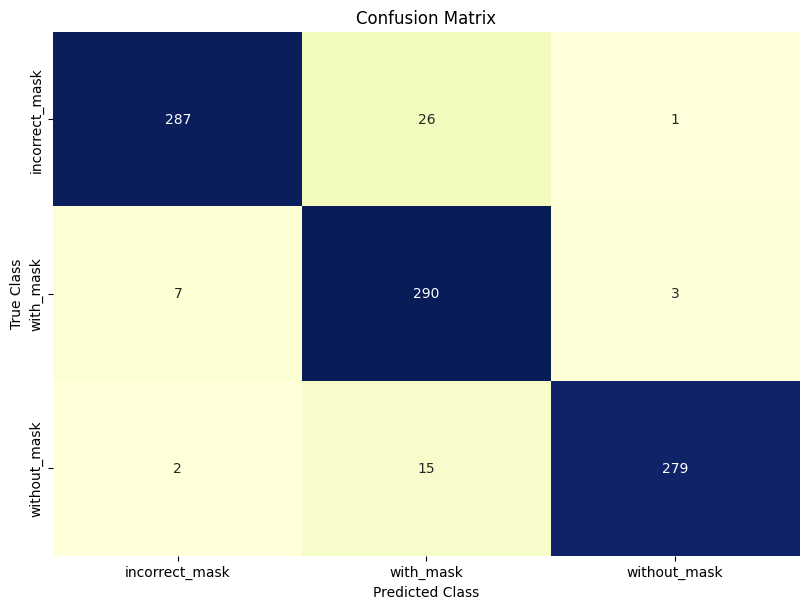

Epoch: 7, Training Loss: 0.1276, Train Accuracy = 0.9578, Validation Loss: 0.1661, Val Accuracy = 0.9407


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


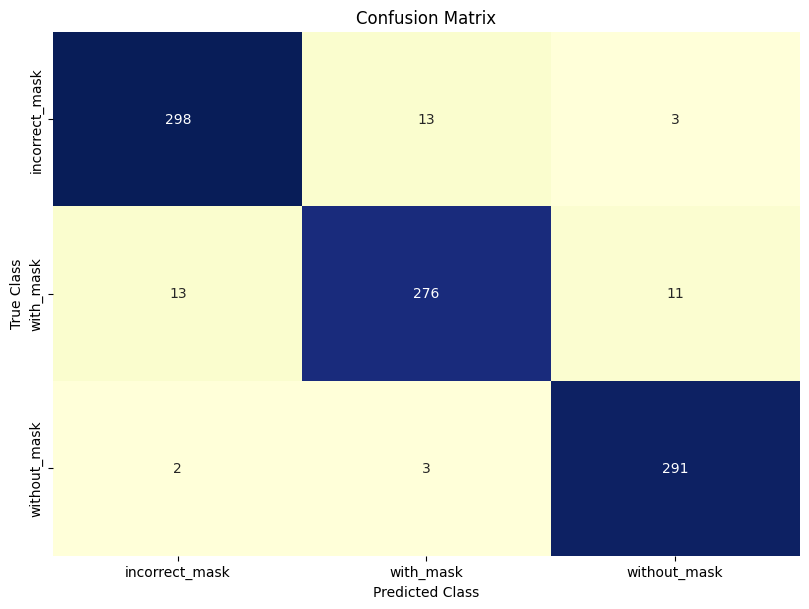

Epoch: 8, Training Loss: 0.1195, Train Accuracy = 0.9601, Validation Loss: 0.1266, Val Accuracy = 0.9505


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


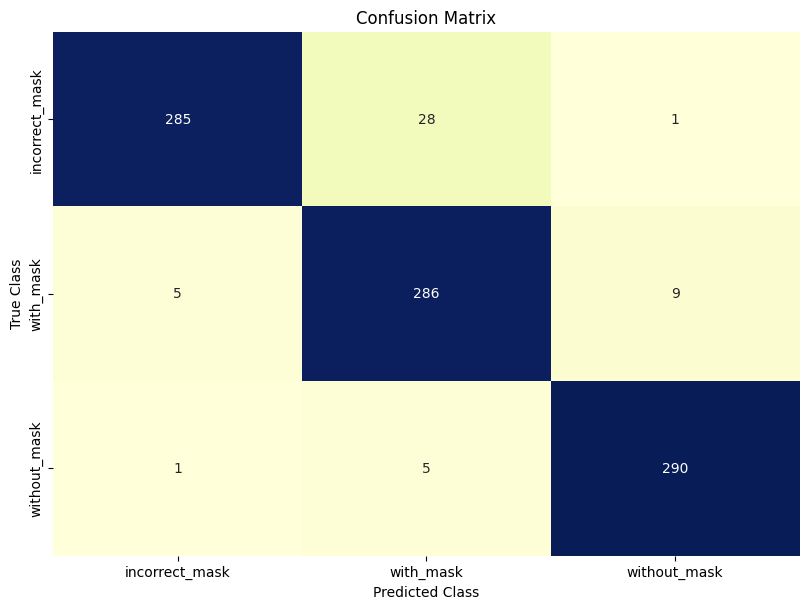

Epoch: 9, Training Loss: 0.1147, Train Accuracy = 0.9617, Validation Loss: 0.1371, Val Accuracy = 0.9462


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


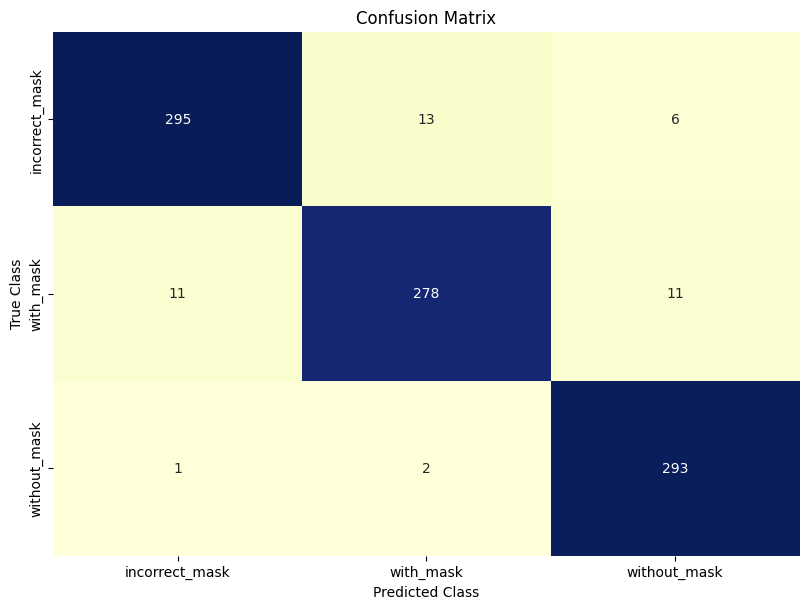

Epoch: 10, Training Loss: 0.1059, Train Accuracy = 0.9635, Validation Loss: 0.1209, Val Accuracy = 0.9516


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


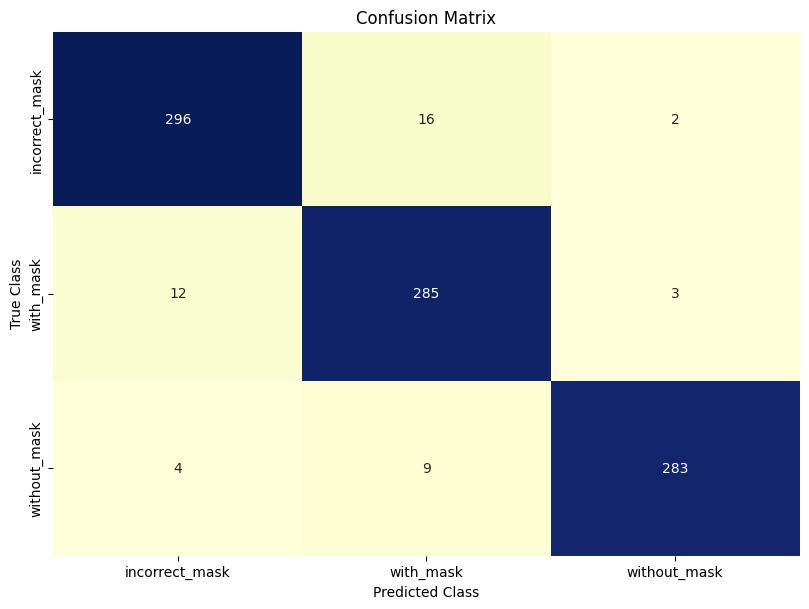

Epoch: 11, Training Loss: 0.1057, Train Accuracy = 0.9646, Validation Loss: 0.1257, Val Accuracy = 0.9495


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


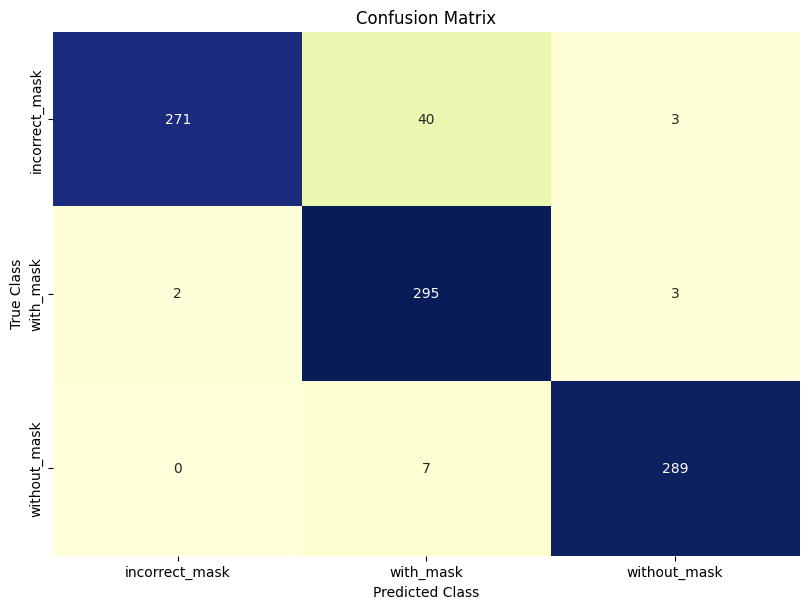

Epoch: 12, Training Loss: 0.1042, Train Accuracy = 0.9658, Validation Loss: 0.1860, Val Accuracy = 0.9396


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


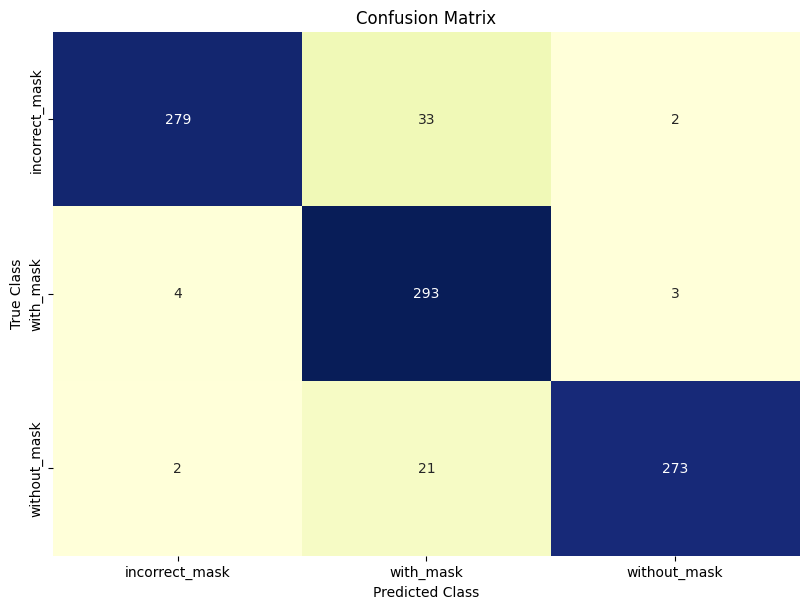

Epoch: 13, Training Loss: 0.1002, Train Accuracy = 0.9679, Validation Loss: 0.1900, Val Accuracy = 0.9286


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


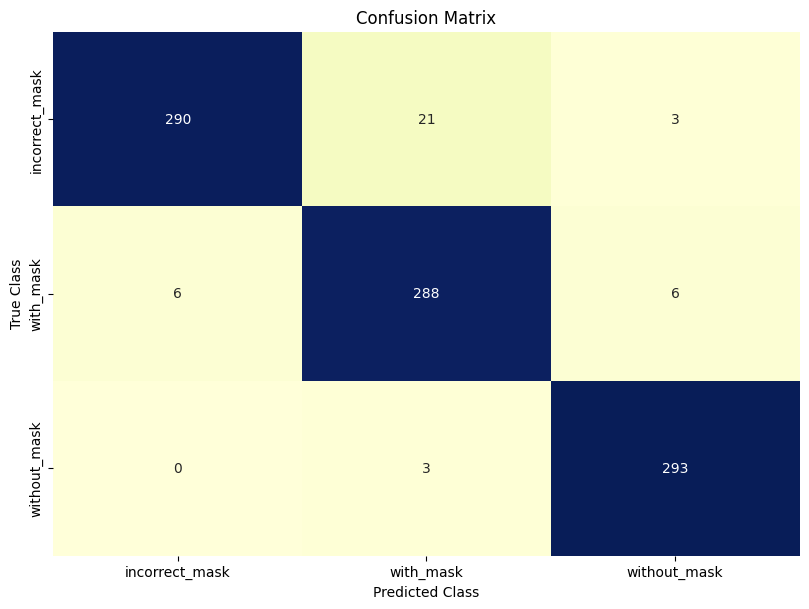

Epoch: 14, Training Loss: 0.0911, Train Accuracy = 0.9684, Validation Loss: 0.1193, Val Accuracy = 0.9571


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


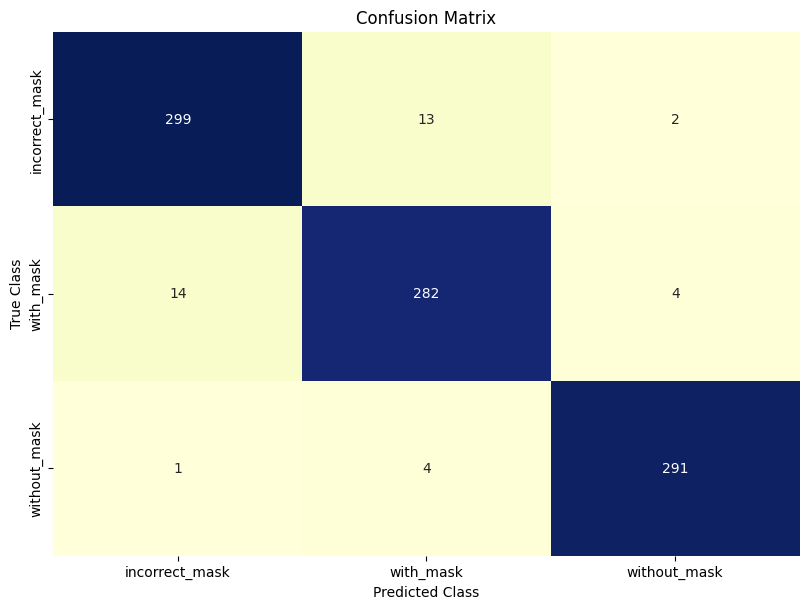

Epoch: 15, Training Loss: 0.0883, Train Accuracy = 0.9711, Validation Loss: 0.1187, Val Accuracy = 0.9582


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


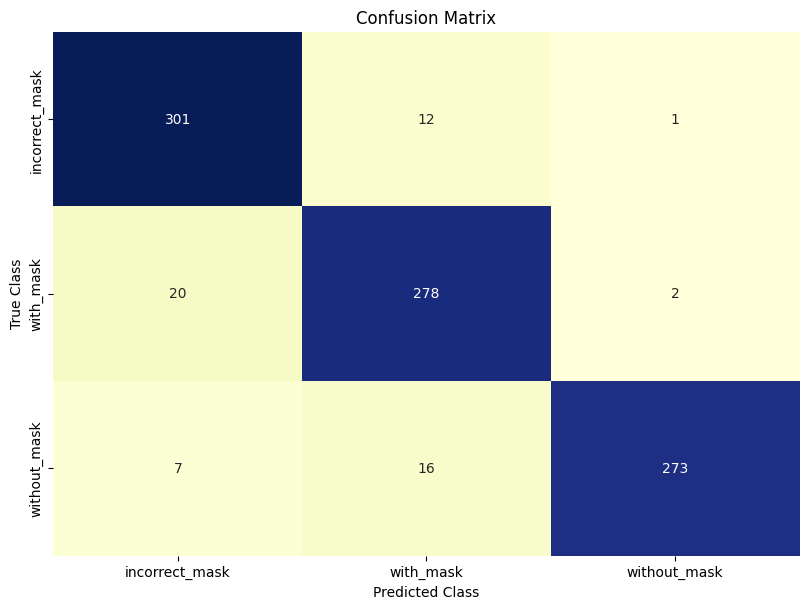

Epoch: 16, Training Loss: 0.0828, Train Accuracy = 0.9737, Validation Loss: 0.1704, Val Accuracy = 0.9363


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


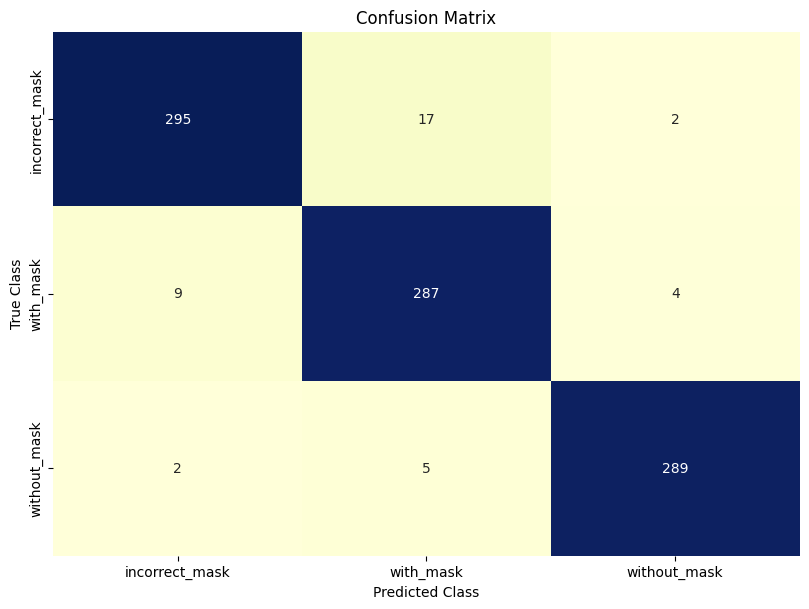

Epoch: 17, Training Loss: 0.0860, Train Accuracy = 0.9704, Validation Loss: 0.1216, Val Accuracy = 0.9571


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


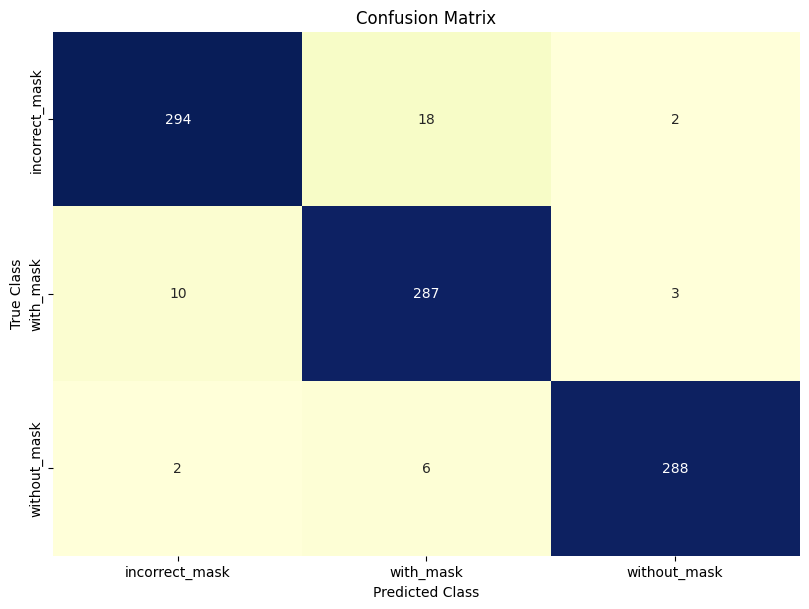

Epoch: 18, Training Loss: 0.0800, Train Accuracy = 0.9725, Validation Loss: 0.1229, Val Accuracy = 0.9549


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


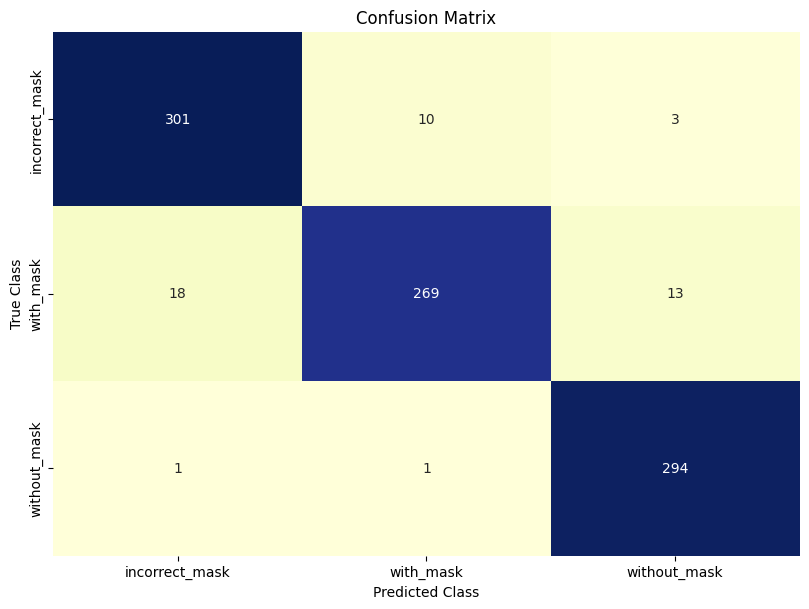

Epoch: 19, Training Loss: 0.0940, Train Accuracy = 0.9690, Validation Loss: 0.1402, Val Accuracy = 0.9495


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


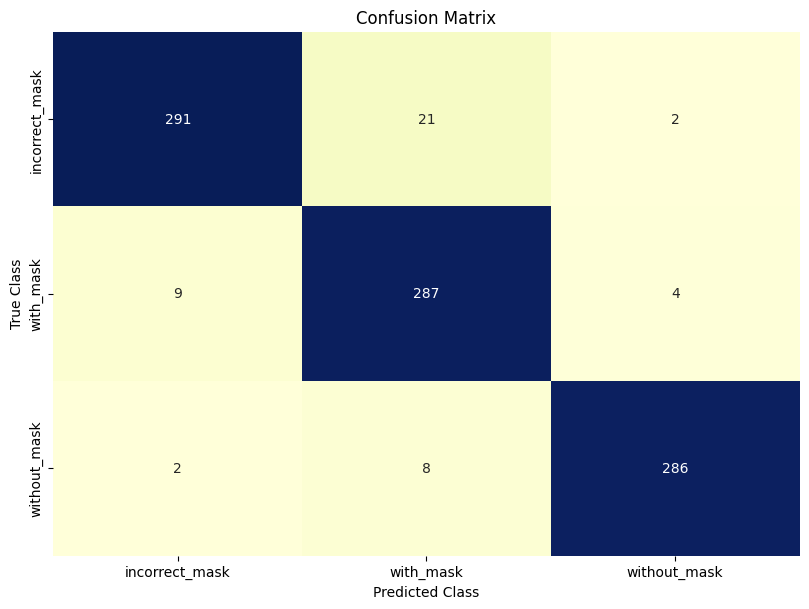

Epoch: 20, Training Loss: 0.0753, Train Accuracy = 0.9738, Validation Loss: 0.1270, Val Accuracy = 0.9495


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


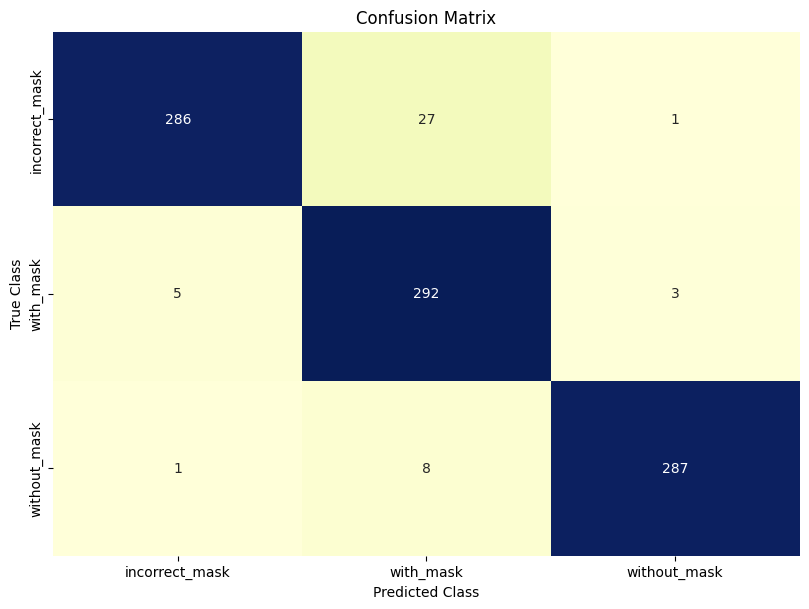

Epoch: 21, Training Loss: 0.0764, Train Accuracy = 0.9752, Validation Loss: 0.1350, Val Accuracy = 0.9505


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


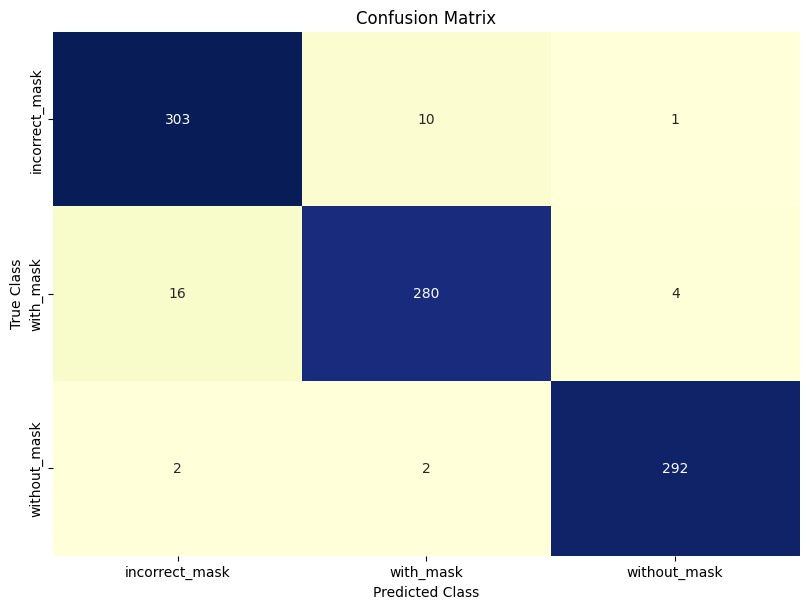

Epoch: 22, Training Loss: 0.0672, Train Accuracy = 0.9767, Validation Loss: 0.1024, Val Accuracy = 0.9615


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


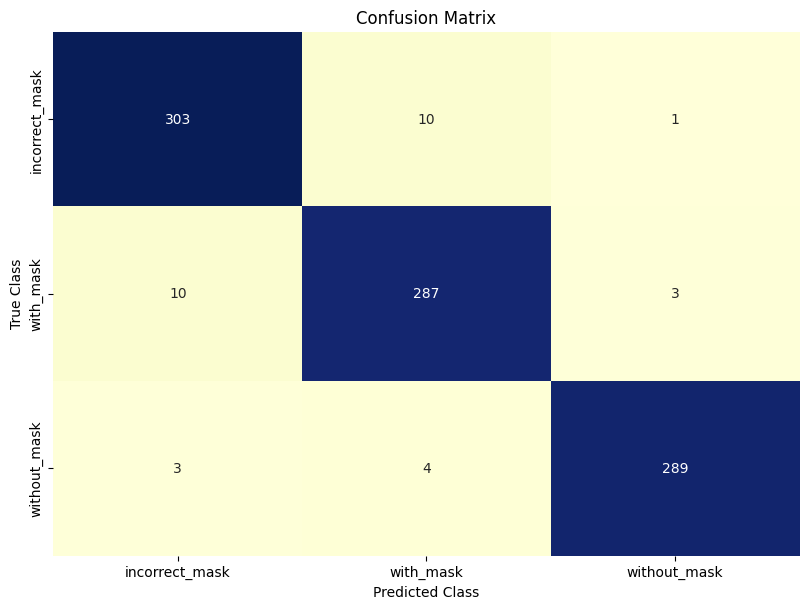

Epoch: 23, Training Loss: 0.0733, Train Accuracy = 0.9761, Validation Loss: 0.1108, Val Accuracy = 0.9659


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


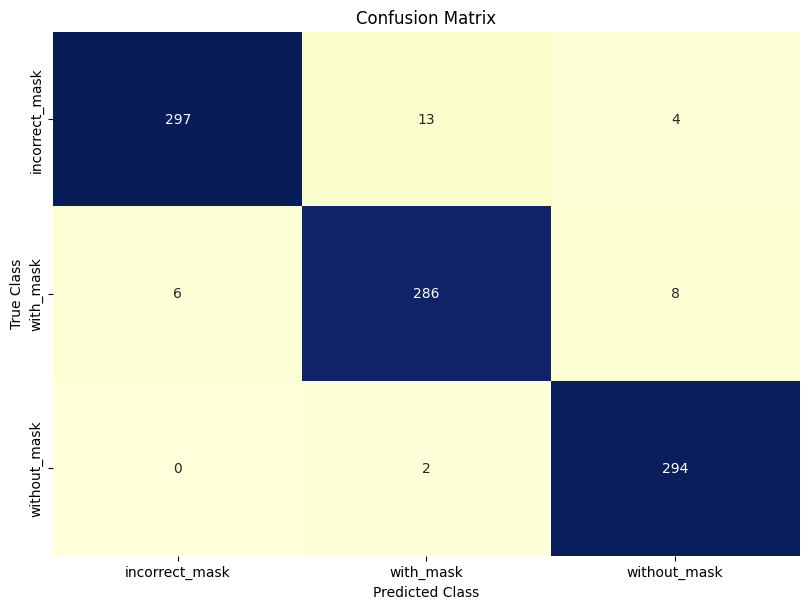

Epoch: 24, Training Loss: 0.0716, Train Accuracy = 0.9755, Validation Loss: 0.1223, Val Accuracy = 0.9637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


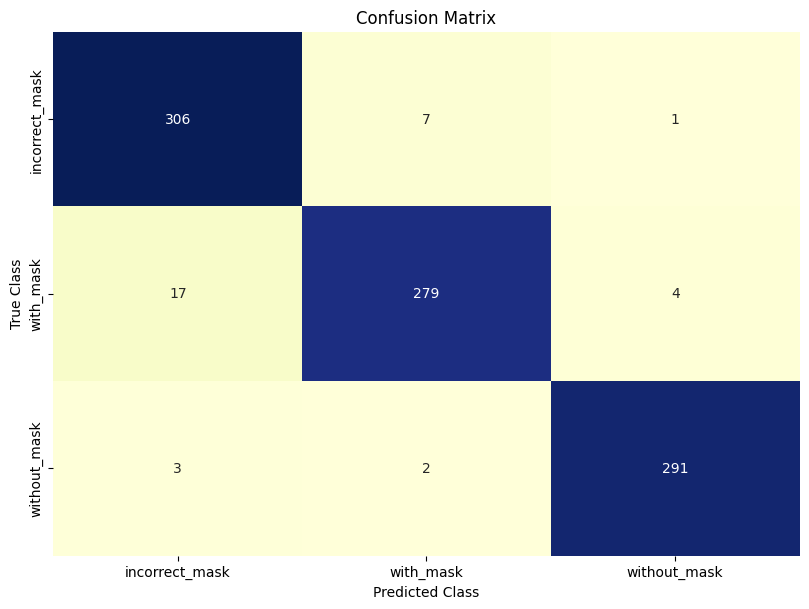

Epoch: 25, Training Loss: 0.0697, Train Accuracy = 0.9764, Validation Loss: 0.1090, Val Accuracy = 0.9626


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


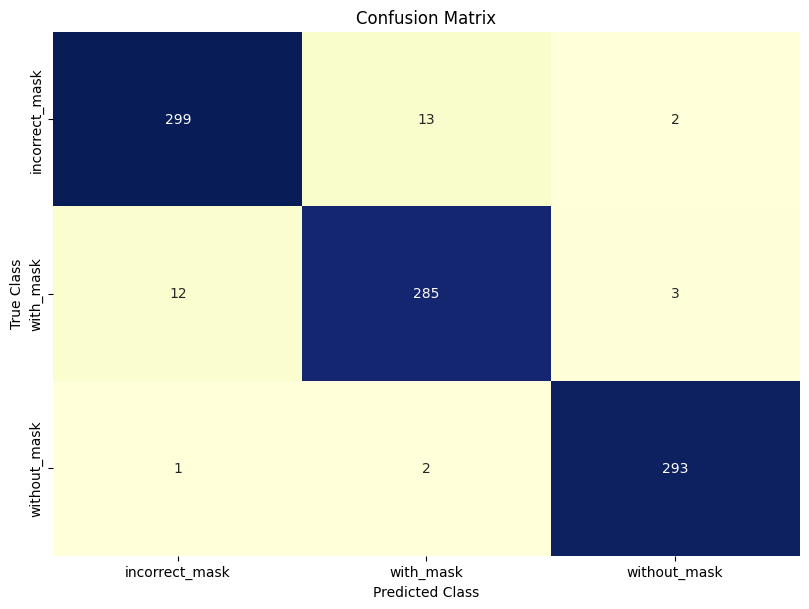

Epoch: 26, Training Loss: 0.0753, Train Accuracy = 0.9753, Validation Loss: 0.1055, Val Accuracy = 0.9637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


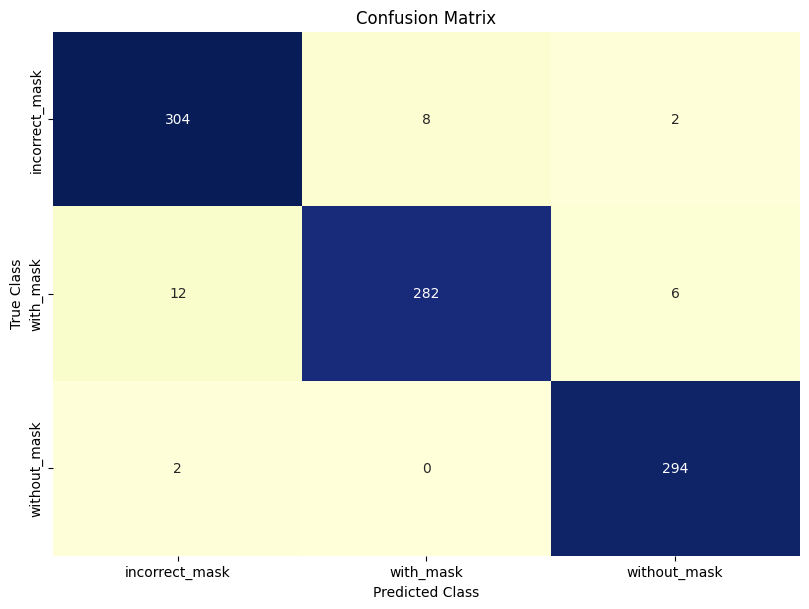

Epoch: 27, Training Loss: 0.0762, Train Accuracy = 0.9751, Validation Loss: 0.0993, Val Accuracy = 0.9670


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


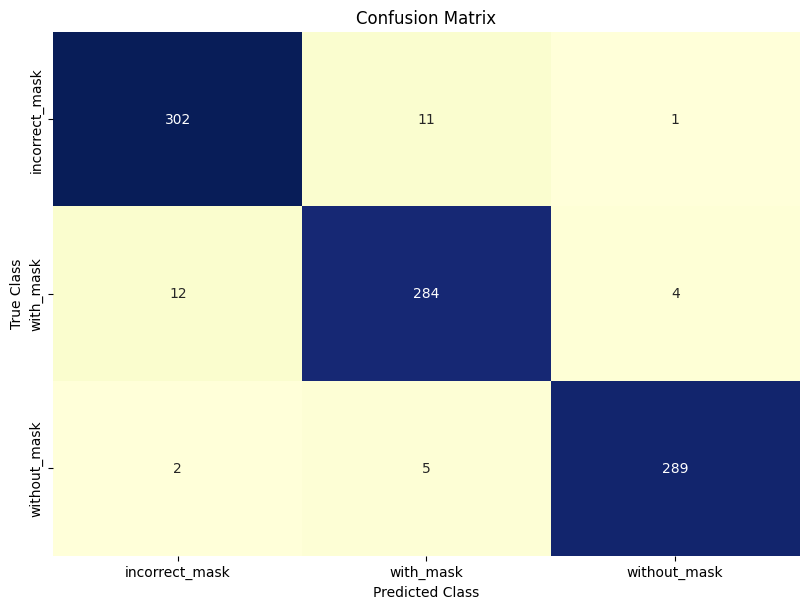

Epoch: 28, Training Loss: 0.0639, Train Accuracy = 0.9784, Validation Loss: 0.1268, Val Accuracy = 0.9615


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


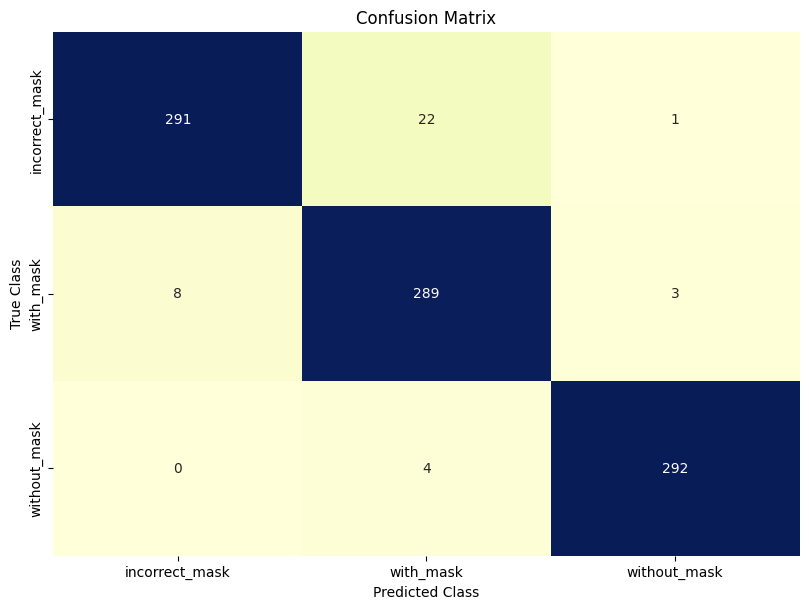

Epoch: 29, Training Loss: 0.0646, Train Accuracy = 0.9789, Validation Loss: 0.1215, Val Accuracy = 0.9582


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


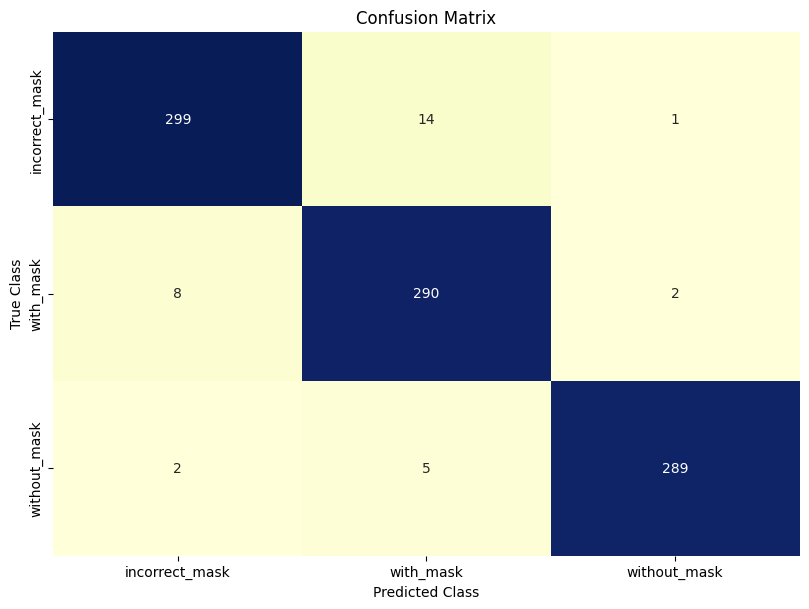

Epoch: 30, Training Loss: 0.0527, Train Accuracy = 0.9814, Validation Loss: 0.0945, Val Accuracy = 0.9648


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


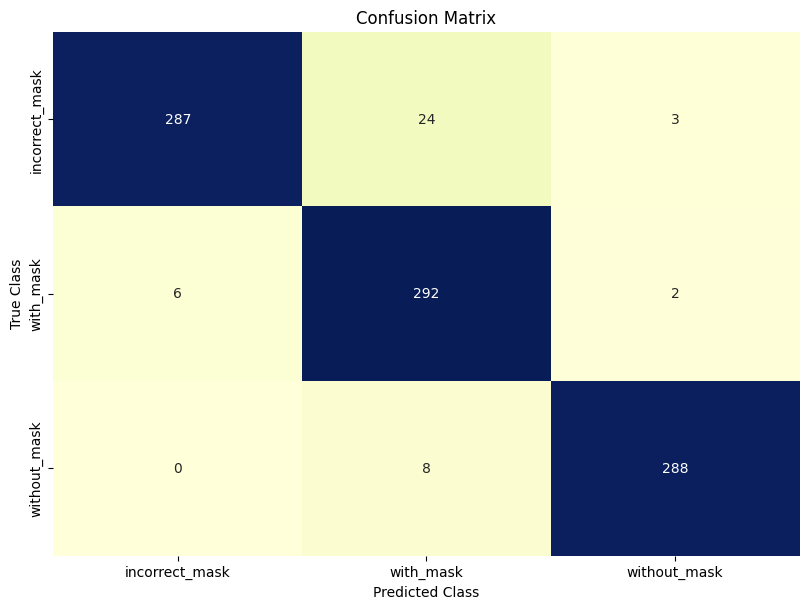

Epoch: 31, Training Loss: 0.0583, Train Accuracy = 0.9788, Validation Loss: 0.1573, Val Accuracy = 0.9527


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


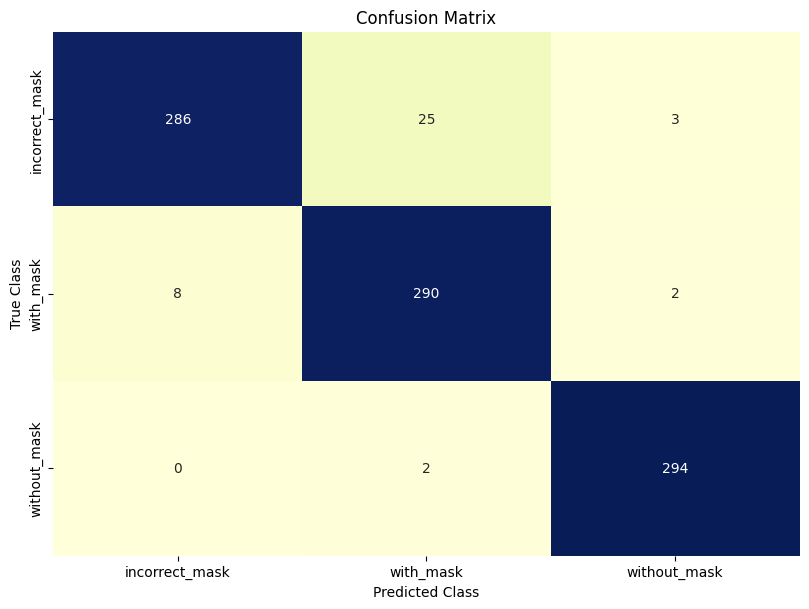

Epoch: 32, Training Loss: 0.0697, Train Accuracy = 0.9787, Validation Loss: 0.1241, Val Accuracy = 0.9560


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


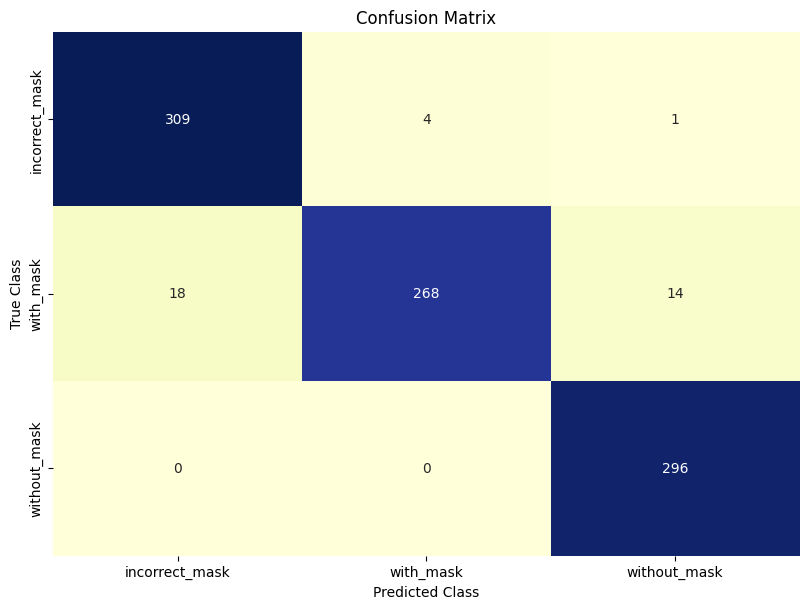

Epoch: 33, Training Loss: 0.0582, Train Accuracy = 0.9799, Validation Loss: 0.1085, Val Accuracy = 0.9593


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


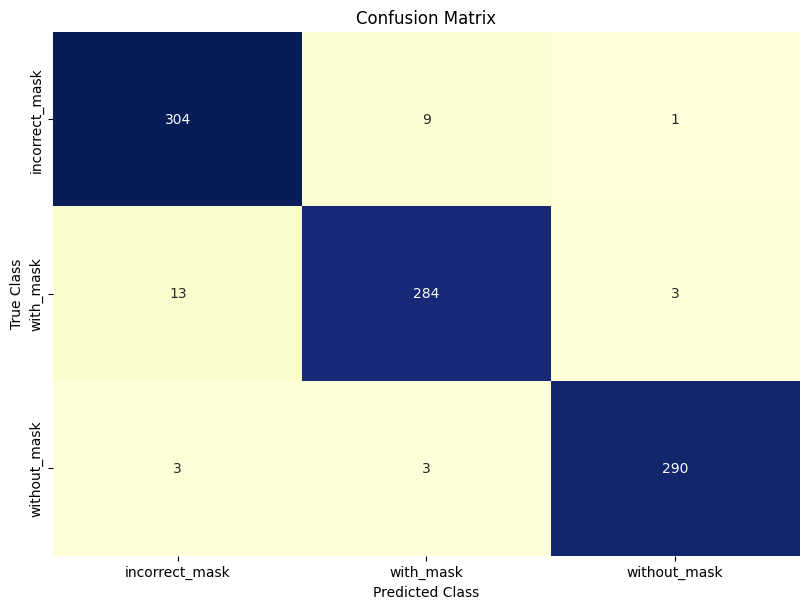

Epoch: 34, Training Loss: 0.0487, Train Accuracy = 0.9823, Validation Loss: 0.1096, Val Accuracy = 0.9648


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


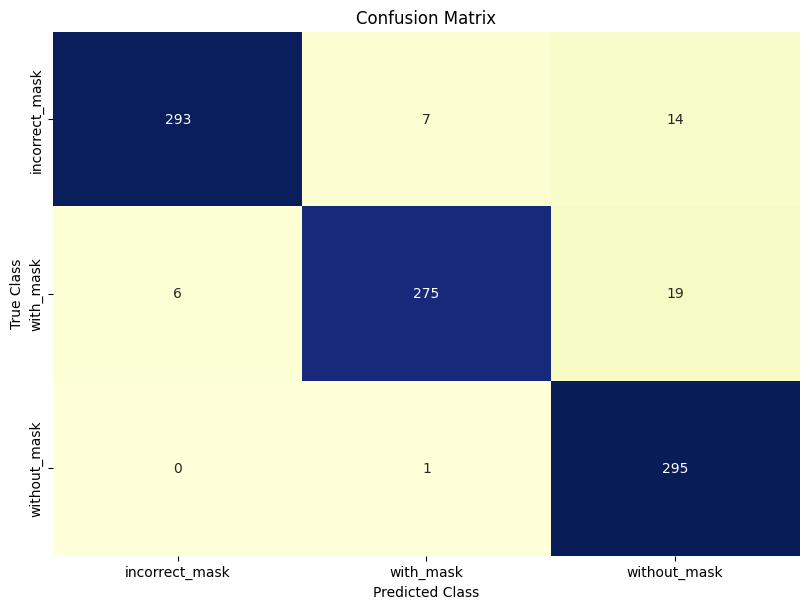

Epoch: 35, Training Loss: 0.0534, Train Accuracy = 0.9824, Validation Loss: 0.2324, Val Accuracy = 0.9484


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


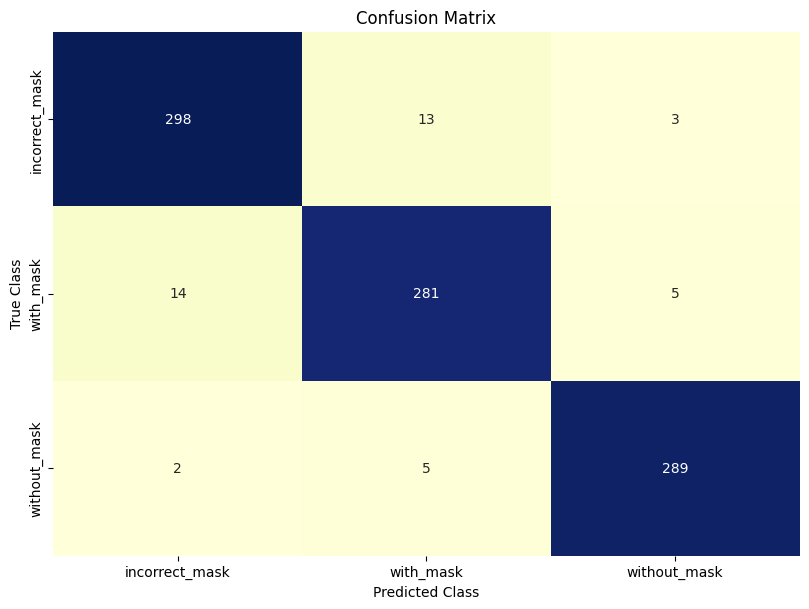

Epoch: 36, Training Loss: 0.0820, Train Accuracy = 0.9700, Validation Loss: 0.1450, Val Accuracy = 0.9538


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


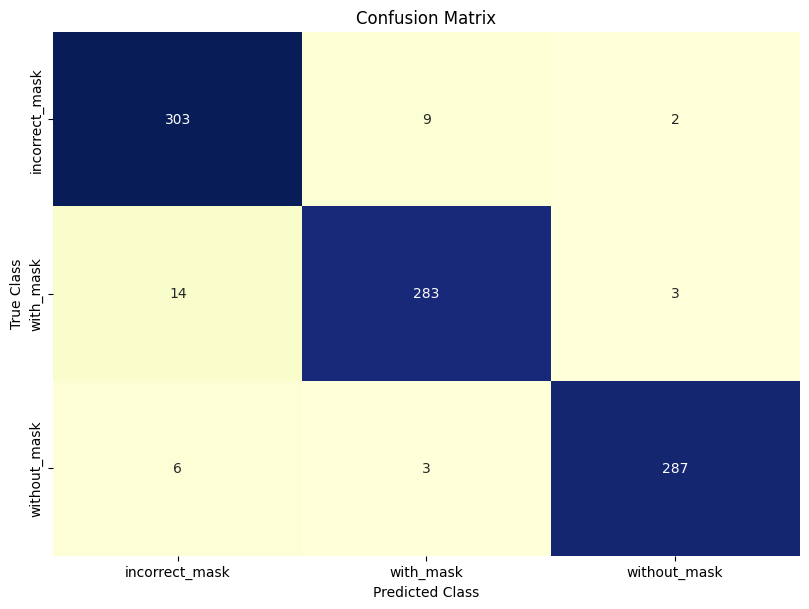

Epoch: 37, Training Loss: 0.0512, Train Accuracy = 0.9837, Validation Loss: 0.1242, Val Accuracy = 0.9593


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


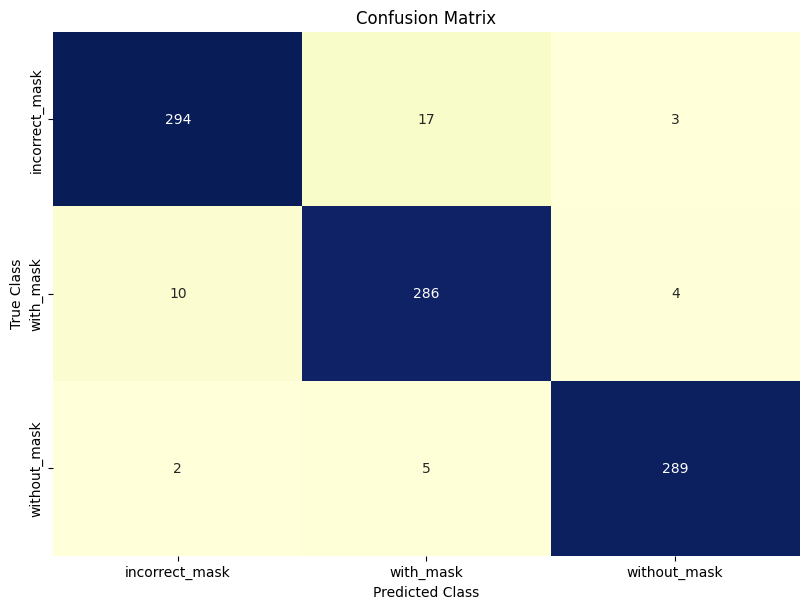

Epoch: 38, Training Loss: 0.0567, Train Accuracy = 0.9803, Validation Loss: 0.1430, Val Accuracy = 0.9549


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


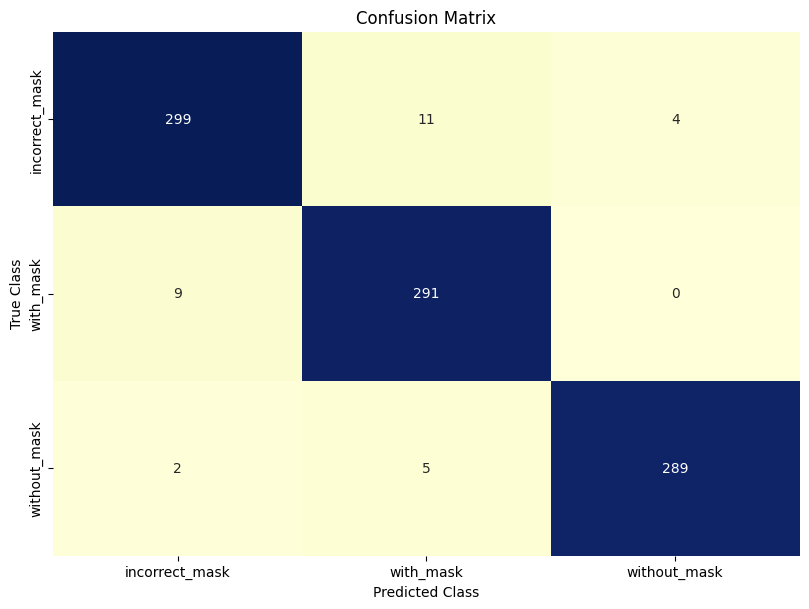

Epoch: 39, Training Loss: 0.0486, Train Accuracy = 0.9840, Validation Loss: 0.1207, Val Accuracy = 0.9659


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


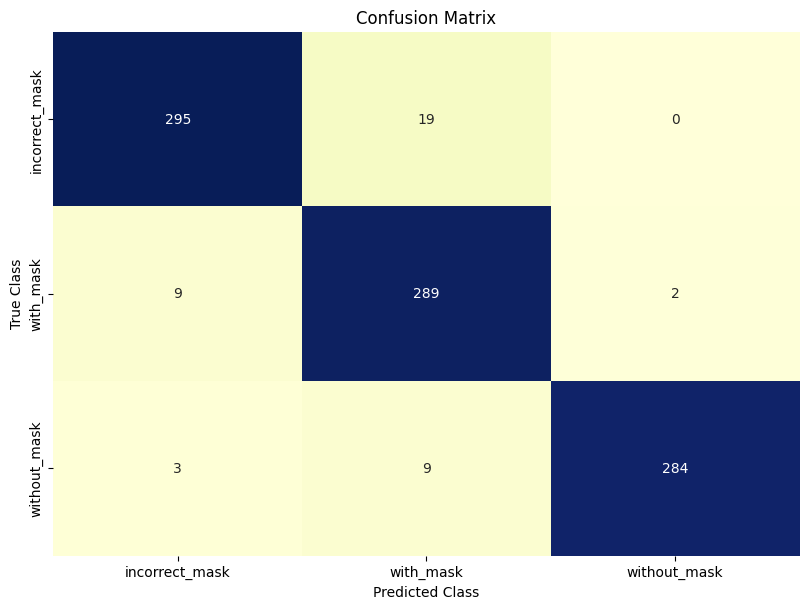

Epoch: 40, Training Loss: 0.0524, Train Accuracy = 0.9819, Validation Loss: 0.1328, Val Accuracy = 0.9538


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


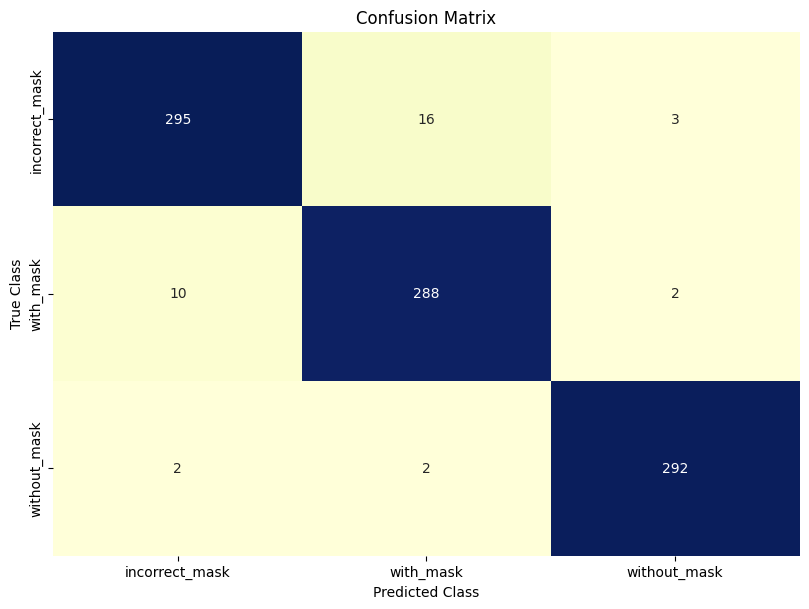

Epoch: 41, Training Loss: 0.0443, Train Accuracy = 0.9841, Validation Loss: 0.1004, Val Accuracy = 0.9615


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


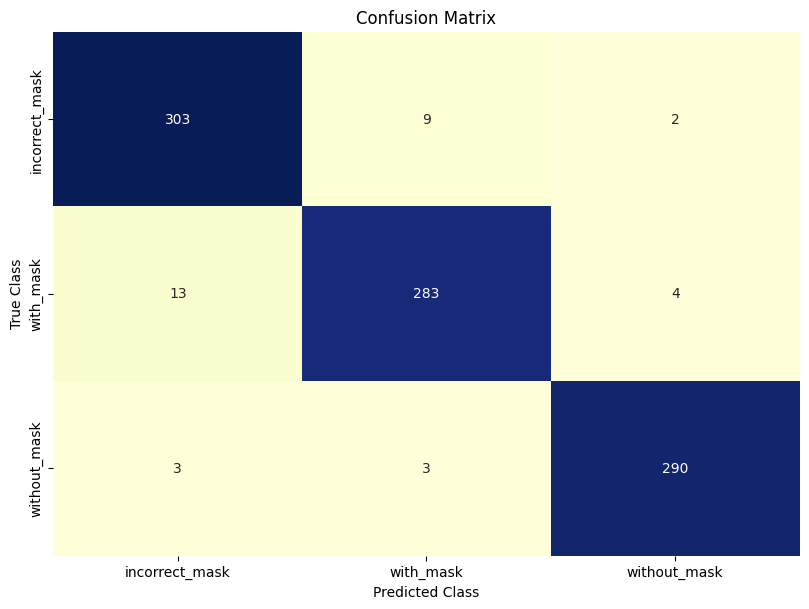

Epoch: 42, Training Loss: 0.0383, Train Accuracy = 0.9868, Validation Loss: 0.1472, Val Accuracy = 0.9626


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


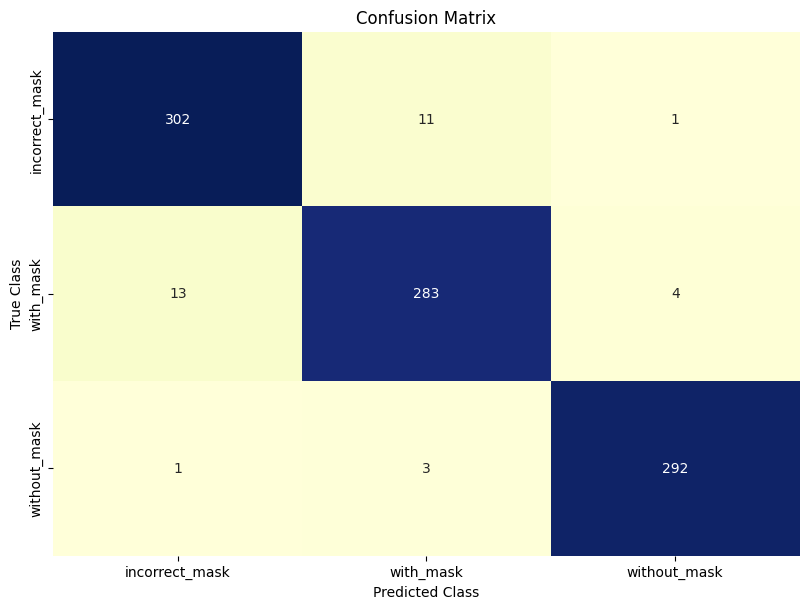

Epoch: 43, Training Loss: 0.0473, Train Accuracy = 0.9841, Validation Loss: 0.1058, Val Accuracy = 0.9637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


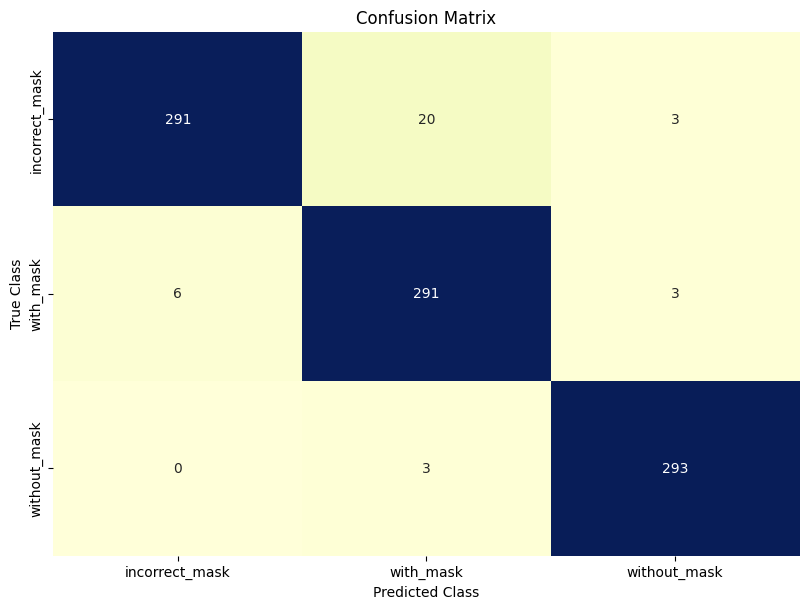

Epoch: 44, Training Loss: 0.0514, Train Accuracy = 0.9839, Validation Loss: 0.1608, Val Accuracy = 0.9615


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


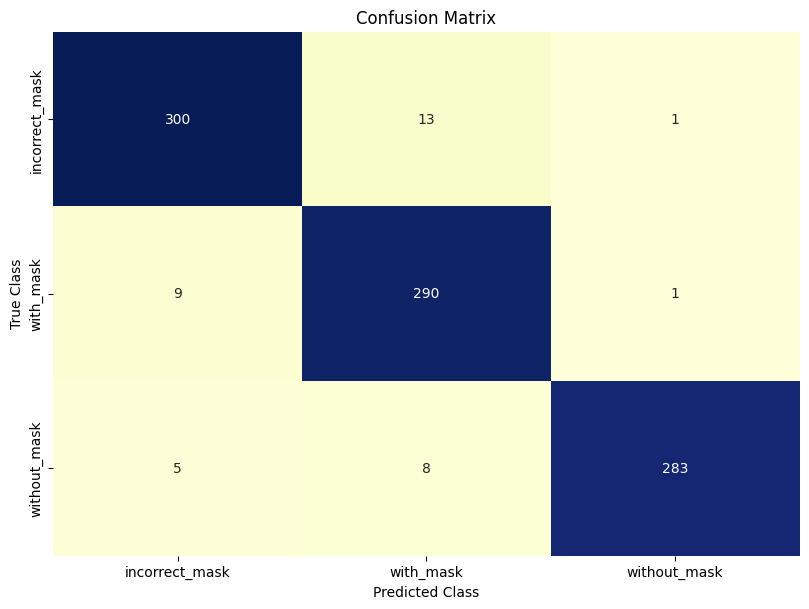

Epoch: 45, Training Loss: 0.0379, Train Accuracy = 0.9863, Validation Loss: 0.1408, Val Accuracy = 0.9593


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


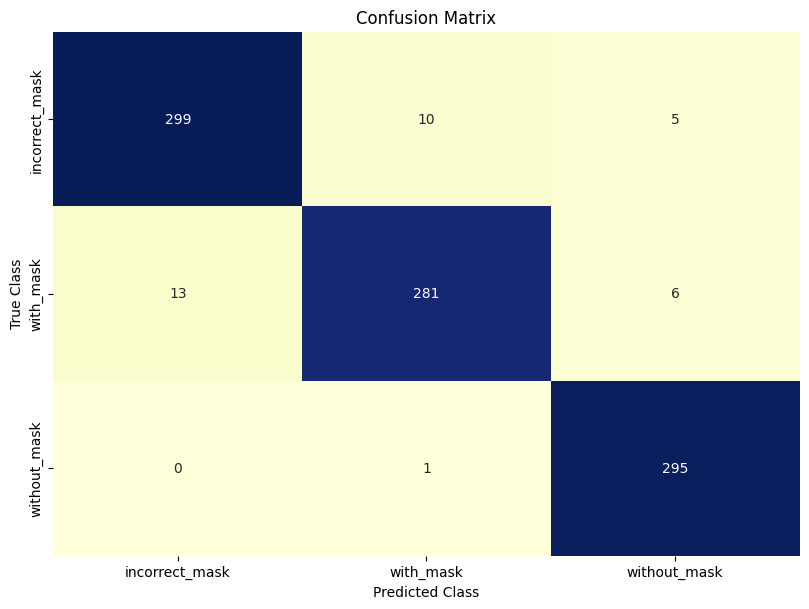

Epoch: 46, Training Loss: 0.0464, Train Accuracy = 0.9857, Validation Loss: 0.1373, Val Accuracy = 0.9615


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


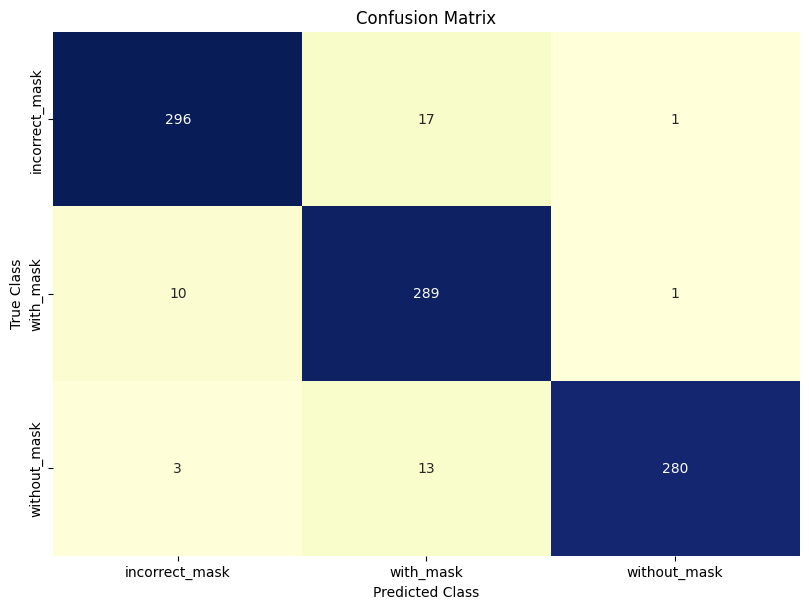

Epoch: 47, Training Loss: 0.0485, Train Accuracy = 0.9844, Validation Loss: 0.1544, Val Accuracy = 0.9505


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


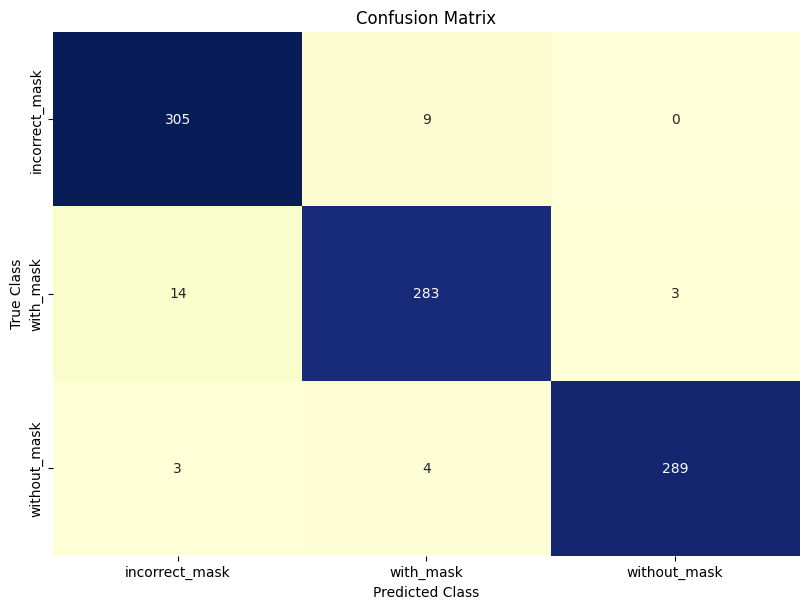

Epoch: 48, Training Loss: 0.0470, Train Accuracy = 0.9831, Validation Loss: 0.1688, Val Accuracy = 0.9637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


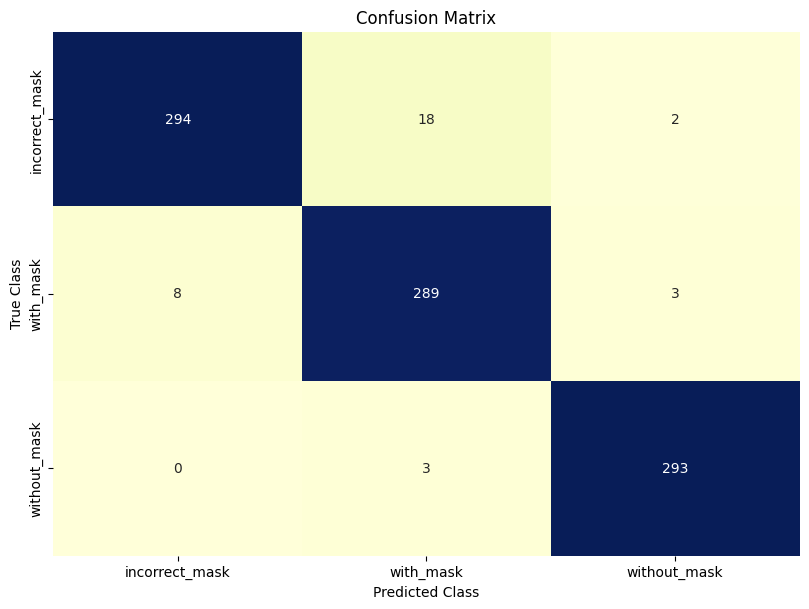

Epoch: 49, Training Loss: 0.0436, Train Accuracy = 0.9858, Validation Loss: 0.1033, Val Accuracy = 0.9626


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


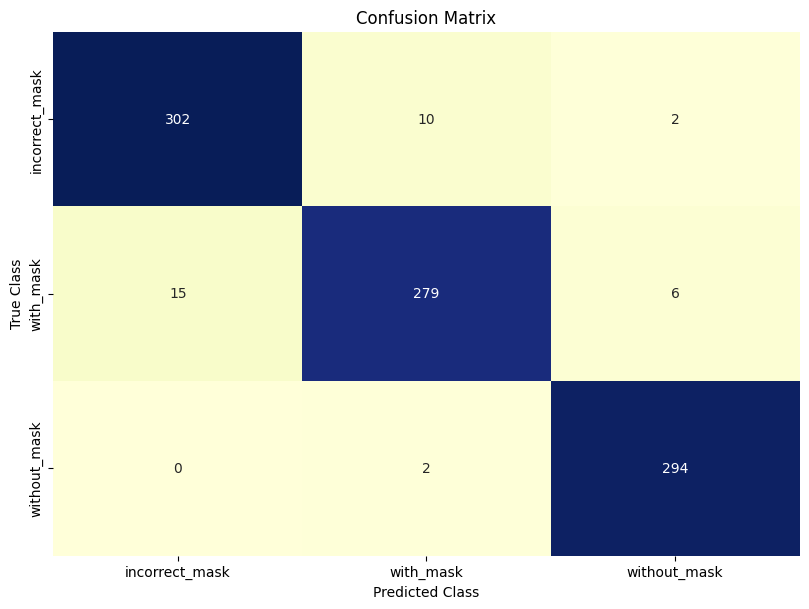

Epoch: 50, Training Loss: 0.0479, Train Accuracy = 0.9842, Validation Loss: 0.1344, Val Accuracy = 0.9615


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


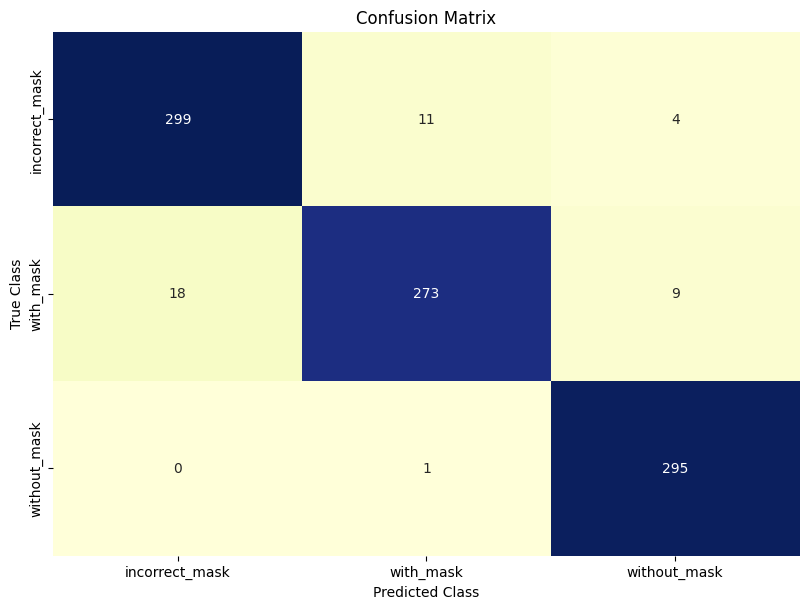

Epoch: 51, Training Loss: 0.0368, Train Accuracy = 0.9875, Validation Loss: 0.1533, Val Accuracy = 0.9527


In [ ]:
#train the model first 100 epochs
train(model, optimizer,loss,dataloaders['train'],dataloaders['test'],100,device)

In [ ]:
#test the model
test_model(model)

In [ ]:
#save the model
torch.save(model, "./firstHundread.pth")